# HOUSING MONTE CARLO SIMULATION

This is a quick analysis on a specific condo found in the Toronto market. Based on historical House Price Indices released by MLS, I try to assess how much it would take for the price of the condo to appreciate past a certain threshold. I use different amortization periods to see if it makes a difference.

This is still a pretty superficial analysis. Later iterations will look at macro-economic trends to identify the current real estate cycle and incorporate more robust real estate analysis models.

## DATA PREPARATION

I created two python objects (included in the repo) Mortgage and House to help with this analysis. This will also provide the required flexibility for future analysis.

In [2]:
#Import required modules

import housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format #Pretty accounting format
np.random.seed(12345) #set a specific seed to get consistent results

With the modules loaded, it's time to load our required data: the MLS House Price Index (HPI). This dataset can be downloaded free from the Canadian Real Estate Association (CREA) website. [Here](https://www.crea.ca/housing-market-stats/mls-home-price-index/) is a link.

"Average or median prices can change a lot from one month to the next and paint an inaccurate or even unhelpful picture of price values and trends. The MLS® HPI is based on the value home buyers assign to various housing attributes, which tend to evolve gradually over time. It therefore provides an “apples to apples” comparison of home prices across the entire country."

I use this measure to derive the estimated monthly growth rate of an apartment.

In [3]:
mls_stats = pd.read_excel('MLS HPI.xlsx', sheet_name='Greater_Toronto')

In [4]:
#Prepare MLS data

mls_stats['Date'] = pd.to_datetime(mls_stats['Date'])
mls_stats['Year'] = mls_stats['Date'].dt.year
mls_stats['Apartment pct change'] = mls_stats['Apartment_HPI'].pct_change()
apt_growth_rates = mls_stats['Apartment pct change'].dropna()

Next we create a helper function that will allow us to run Monte Carlo simulations on a particular real estate property. For each iteration of the simulation, a randomly selected monthly growth rate is applied to the price of the property. This new price is then compared to the costs incurred in purchasing the property up to this point (referenced as the breakeven point). Once the price of the property appreciates above the breakeven point by a particular margin (in this case 20%), the iteration stops and records how many years have passed. 

Future analysis will better model cash flows (e.g. rental income) and incorporate more robust profitibability metrics (e.g. IRR) as well as other macro-economic trends (e.g. interest rate risk).

The code can be found below.

In [5]:
#HELPER FUNCTIONS

NUMBERS_OF_MONTHS = 12
BEDROOMS = 1 #bedrooms do not affect this simulation but required to create a House object
BATHROOMS = 1 #bathrooms do not affect this simulation but required to create a House object

def monte_carlo_simulation(principal, down_payment, yearly_rate, amortization, yearly_property_taxes, monthly_maintenance_fees, growth_rates=apt_growth_rates, iterations=1000, total_appreciation_threshold=0.2):
    '''Runs a Monte Carlo Simulation to assess how many years it takes for the price to appreciate past a certain threshold - based on historical growth rates
    
    Keyword Arguments:
        principal -- Price of the property in dollars
        down_payment -- Ratio of the down payment in percentages (e.g. 0.2)
        yearly_rate -- Rate of the mortgage loan in percentages (e.g. 0.04)
        amortization -- Duration of the mortgage in years
        yearly_property_taxes -- Yearly Property taxes in dollars
        monthly_maintenance_fees -- Monthly maintenance fees in dollars
        iterations -- Number of simulations
    '''
    
    simulation = []
    for i in range(iterations):
        condo_mortgage = housing_model.Mortgage(principal, down_payment, yearly_rate, amortization)
        condo = housing_model.House(principal, BEDROOMS, BATHROOMS, yearly_property_taxes, monthly_maintenance_fees)
        breakeven = condo_mortgage.total_paid + condo_mortgage.balance + condo_mortgage.period * (condo.monthly_taxes + condo.maintenance_fees)
        house_price = condo.house_price

        while house_price < breakeven * (1 + total_appreciation_threshold):
            growth_rate = np.random.choice(growth_rates)
            condo_mortgage.update_balance()
            breakeven = condo_mortgage.total_paid + condo_mortgage.balance + condo_mortgage.period * (condo.monthly_taxes + condo.maintenance_fees)
            condo.update_house_price(growth_rate)
            house_price = condo.house_price
        simulation.append(condo_mortgage.period / NUMBERS_OF_MONTHS)
    return simulation

## EXPLORATORY DATA ANALYSIS

Let's take a quick look at historical growth rates. While we can see a significant rise of growth rates between 2016 and 2018, the distribution still seems normal (while somewhat right skewed). Future analysis will dig deeper in growth rates trends and examine its relationship with the well established real estate cycles (expansion, hypersupply, recession and recovery). 

count   173.000
mean      0.006
std       0.009
min      -0.024
25%       0.001
50%       0.005
75%       0.010
max       0.060
Name: Apartment pct change, dtype: float64

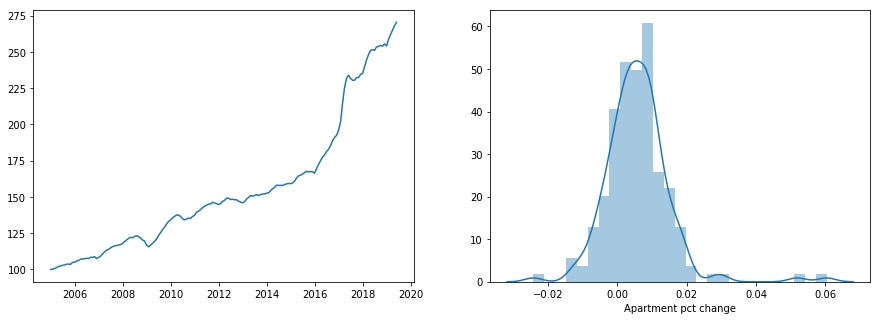

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
pct_change = mls_stats['Apartment pct change'].dropna()

axes[0].plot(mls_stats['Date'], mls_stats['Apartment_HPI'])
sns.distplot(pct_change, ax=axes[1])
pct_change.describe()

## Monte Carlo Simulation by Amortization Period

With our data ready, we can run the Monte Carlo simulation on a 1 bedroom condo selected from the MLS Realtor.ca website (details found below). I ran the simulation with different amortization period. My hypothesis was that a shorter amortization period will lead to a significant reduction in the amount of time it takes to turn a profit (based on house price appreciation)

In [7]:
YEARLY_RATE = 0.04
PRINCIPAL = 239900
DOWN_PAYMENT = 0.25
YEARLY_PROPERTY_TAXES = 1020.52 
MONTHLY_MAINTENANCE_FEES = 631.0

simulations = []
amortization_years = [15, 25, 30] 
for amortization in amortization_years:
    simulation = monte_carlo_simulation(PRINCIPAL, DOWN_PAYMENT, YEARLY_RATE, amortization, YEARLY_PROPERTY_TAXES, MONTHLY_MAINTENANCE_FEES)
    simulations.append(simulation)

,15 Year,25 Year,30 Year
count,"1,000.000","1,000.000","1,000.000"
mean,8.539,9.213,9.172
std,2.583,2.945,3.082
min,2.167,2.000,1.417
25%,6.750,7.000,7.083
50%,8.333,9.083,9.083
75%,10.250,11.167,11.021
max,19.167,19.333,22.000


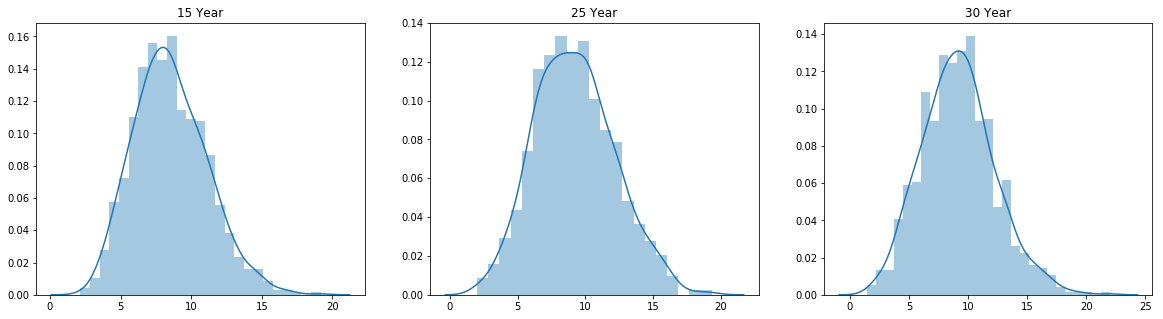

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

describe_stats = []
for index, amortization_year in enumerate(amortization_years):
    sns.distplot(simulations[index], ax=axes[index])
    axes[index].set_title(str(amortization_year) + ' Year')
    describe_stats.append(pd.Series(simulations[index], name=str(amortization_year) + ' Year').describe())
pd.concat([describe_stats[0], describe_stats[1], describe_stats[2]], axis=1)

Overall, the distributions don't vary that widely when choosing different amortization periods. A shorter amortization did lead to less time to turn a profit on average, but not by much. Meanwhile, a shorter amortization period incurs a higher monthly mortgage payment, which might have been used for other investments.

Future analysis will look into that opportunity cost (e.g. investing that balance in an S&P500 index fund or ETF)